In [1]:
import yahoo_fin.stock_info as si
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from pandas import read_html

nan=np.nan

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from pandas_datareader import data
from datetime import datetime

In [3]:
def GrahamInVal (sticker):
    #sticker = "CRM"

    # Read EPS
    url_Summary = 'https://finance.yahoo.com/quote/' + sticker
    dframe_list_Summary = pd.read_html(url_Summary)
    Summary_tab = dframe_list_Summary[1]
    EPS_str = Summary_tab.loc[3,1]
    EPS = float(EPS_str)

    # Read P/E
    #PERatio_str = Summary_tab.loc[2,1]
    #PERatio_read = float(PERatio_str)
    PERatio_fixed = 7.0
    PERatio = PERatio_fixed

    # Read 5 Yr Growth Rate
    url_Analysis = 'https://finance.yahoo.com/quote/' + sticker + '/analysis?p=' + sticker
    dframe_list_Analysis = pd.read_html(url_Analysis)
    GrowthEst_tab = dframe_list_Analysis[5]
    GrowthEst_str = GrowthEst_tab.loc[4,sticker]
    GrowthEst = float(GrowthEst_str[:-1])
    GrowthScale = 1

    # Read AAACorpBond Yield
    url_AAACorpBond = 'https://ycharts.com/indicators/moodys_seasoned_aaa_corporate_bond_yield'
    dframe_list_AAACorpBond = pd.read_html(url_AAACorpBond)
    dframe_AAACorpBond = dframe_list_AAACorpBond[0]
    AAACorpBond_str = dframe_AAACorpBond.loc[0,'Unnamed: 1']
    AAACorpBond = float(AAACorpBond_str[:-1])
    CorpBond = 4.4

    IntrinsicVal = round((EPS * (PERatio + (GrowthEst * GrowthScale)) * CorpBond) / AAACorpBond,2)

    # Read Current Val
    Summary_tab = dframe_list_Summary[0]
    PrevClose_str = Summary_tab.loc[0,1]
    PrevClose = round(float(PrevClose_str),2)

    if PrevClose < IntrinsicVal:
        Decision = 'BUY'
    else:
        Decision = 'SELL'

    MarginRaw = (PrevClose/IntrinsicVal)-1
    Margin = round(MarginRaw*100,2)
    #Margin = '{percent:.2%}'.format(percent=MarginRaw)

    return {'Sticker':sticker,
             'IntrinsicVal($)':IntrinsicVal,
             'PrevClose($)':PrevClose,
             'Decision':Decision,
             'Margin(%)':Margin,
             'EPS':EPS,
             'GrowthEst(%)':GrowthEst}

In [4]:
def RiskVal (sticker_list, period):
    end = datetime.now()
    start = datetime(end.year-period, end.month, end.day)

    for stock in sticker_list:
        globals()[stock] = data.DataReader(stock,'yahoo',start,end)

    closing_df = data.DataReader(sticker_list,'yahoo',start,end)['Adj Close']
    tech_rets = closing_df.pct_change()
    rets = tech_rets.dropna()
    risk = 100*rets.quantile([0.05,0.01])

    risk_df = pd.DataFrame(risk.T)
    risk_df.index.names = ['Sticker']
    risk_df.rename({0.05:str(period)+'yr/95% WC Risk%', 0.01:str(period)+'yr/99% WC Risk%'}, axis=1, inplace=True)
    return risk_df

In [5]:
#stock_list = Series(["AAPL"])
stock_list = ['AAPL','NVDA','QCOM','AVGO','PYPL','WIX','OLED','DAL']

#stock_sum = pd.DataFrame(np.array([[nan, nan, nan, nan, nan, nan, nan]]),
stock_sum = pd.DataFrame(np.arange(7*len(stock_list)).reshape((len(stock_list),7)),
                                   columns=['Sticker',
                                            'IntrinsicVal($)',
                                            'PrevClose($)',
                                            'Decision', 
                                            'Margin(%)',
                                            'EPS',
                                            'GrowthEst(%)'])

for i in stock_list:
    ami=GrahamInVal(i)
    ami1 = pd.DataFrame.from_dict(ami, orient='index')
    ami2 = ami1.transpose()
    #print(ami2)
    stock_sum = stock_sum.append(ami2)

stock_sum.set_index('Sticker', inplace=True)
stock_sum.drop(stock_sum.index[0:len(stock_list)], inplace=True)
#stock_sum

risk_df = RiskVal(stock_list,1)
#risk_df

stock_anal=pd.concat([stock_sum, risk_df], axis=1, sort=False)
stock_anal

,IntrinsicVal($),PrevClose($),Decision,Margin(%),EPS,GrowthEst(%),1yr/95% WC Risk%,1yr/99% WC Risk%
Sticker,,,,,,,,
AAPL,486.8,458.43,BUY,-5.83,13.19,12.46,-3.425843,-7.209291
NVDA,241.79,493.48,SELL,104.09,5.35,16.83,-4.296391,-7.765302
QCOM,151.33,112.18,BUY,-25.87,2.36,26.81,-3.964117,-8.907668
AVGO,211.8,330.32,SELL,55.96,5.57,13.05,-4.141507,-9.529489
PYPL,125.56,196.29,SELL,56.33,2.18,23.37,-3.934097,-7.289909
WIX,-106.36,282.69,SELL,-365.79,-2.6,14.57,-4.589140,-11.091967
OLED,145.76,187.34,SELL,28.53,2.16,28.58,-5.014063,-8.943165
DAL,76.67,28.02,BUY,-63.45,-5.71,-14.08,-6.708204,-15.160266


In [6]:
stock = ['GOOG','AMD']
end = datetime.now()
start = datetime(end.year-1, end.month, end.day)
for x in stock:
    globals()[x] = data.DataReader(x,'yahoo',start,end)
        
closing_df = data.DataReader(stock,'yahoo',start,end)['Adj Close']
tech_rets = closing_df.pct_change()
rets = tech_rets.dropna()

days = 365
dt = 1/days
mu = rets.mean()['GOOG']
sigma = rets.std()['GOOG']

In [7]:
mu

0.0012909235803324314

In [8]:
def stock_monte_carlo(start_price,days,mu,sigma):
    price = np.zeros(days)
    price[0] = start_price
    
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    for x in range(1,days):
        shock[x] = np.random.normal(loc=mu*dt,scale=sigma*np.sqrt(dt))
        drift[x] = mu*dt
        price[x] = price[x-1] + (price[x-1] * (drift[x] + shock[x]))
        
    return price

In [9]:
GOOG.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-19,1206.989990,1190.089966,1190.089966,1198.449951,1231600,1198.449951
2019-08-20,1196.060059,1182.109985,1195.250000,1182.689941,915500,1182.689941
2019-08-21,1199.000000,1187.430054,1193.150024,1191.250000,740700,1191.250000
2019-08-22,1198.011963,1178.579956,1194.069946,1189.530029,947500,1189.530029
2019-08-23,1194.079956,1147.750000,1181.989990,1151.290039,1687000,1151.290039


In [21]:
aa=GOOG['Open'][0]
aa

1190.0899658203125

Text(0.5, 1.0, 'Monte Carlo Analysis')

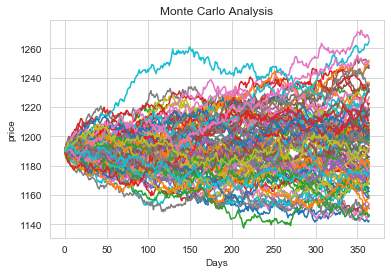

In [10]:
start_price = 1190.09

for run in range(100):
    plt.plot(stock_monte_carlo(start_price,days,mu,sigma))
    
plt.xlabel('Days')
plt.ylabel('price')
plt.title('Monte Carlo Analysis')

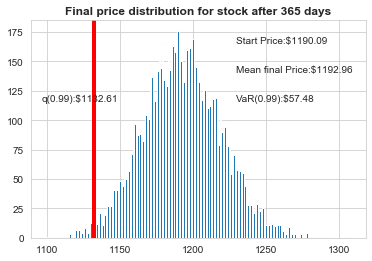

In [11]:
runs = 10000
simulations = np.zeros(runs)

for run in range(runs):
    simulations[run]=stock_monte_carlo(start_price,days,mu,sigma)[days-1]
    
q = np.percentile(simulations,1)

plt.hist(simulations,bins=200)

plt.figtext(0.6,0.8,s="Start Price:$%.2f" %start_price)
plt.figtext(0.6,0.7,"Mean final Price:$%.2f" %simulations.mean())
plt.figtext(0.6,0.6,"VaR(0.99):$%.2f" %(start_price-q,))
plt.figtext(0.15,0.6,"q(0.99):$%.2f" %q)
plt.axvline(x=q,linewidth=4,color='r')
plt.title(u"Final price distribution for stock after %s days" %days, weight='bold');


In [12]:
100*(start_price-q)/start_price

4.830070118172122